In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import erfc
import numba as nb
import plotly.express as px
import plotly.graph_objects as go

In [2]:
@np.vectorize
def W( x, tipe, P, p ):
    if tipe == 'spline':
#        if x >  0.5: return 0.0
#        if x < -0.5: return 0.0
        if P == 1:
            return 1.0
        if P == 2:
            if p == -1/2: return 0.5 * ( 1 - 2 * x )
            if p == +1/2: return 0.5 * ( 1 + 2 * x )
            return 0.0
        if P == 3:
            x2 = x*x
            if p == -1: return 0.125 * ( 1.0 - 4.0 * x + 4.0 * x2 )
            if p ==  0: return 0.25  * ( 3.0           - 4.0 * x2 )
            if p ==  1: return 0.125 * ( 1.0 + 4.0 * x + 4.0 * x2 )
            return 0.0
        if P == 5:
            x2 = x*x; x3 = x2*x; x4 = x2*x2
            if p == -2: return 1/384 * (1   -  8 * x + 24  * x2 - 32 * x3 + 16 * x4)
            if p == -1: return 1/96  * (19  - 44 * x + 24  * x2 + 16 * x3 - 16 * x4)
            if p ==  0: return 1/192 * (115          - 120 * x2           + 48 * x4 )
            if p ==  1: return 1/96  * (19  + 44 * x + 24  * x2 - 16 * x3 - 16 * x4)
            if p ==  2: return 1/384 * (1   +  8 * x + 24  * x2 + 32 * x3 + 16 * x4)
            return 0.0
        if P == 7:
            x2 = x*x; x3 = x2*x; x4 = x2*x2; x5 = x2*x3; x6 = x3*x3
            if p == -3: return 1/46080 * (    1 -    12 * x +   60 * x2 -  160 * x3 +  240 * x4 - 192 * x5 +  64 * x6 )
            if p == -2: return 1/23040 * (  361 -  1416 * x + 2220 * x2 - 1600 * x3 +  240 * x4 + 384 * x5 - 192 * x6 )
            if p == -1: return 1/46080 * (10543 - 17340 * x + 4740 * x2 + 6880 * x3 - 4080 * x4 - 960 * x5 + 960 * x6 )
            if p ==  0: return 1/11520 * ( 5887 -     0 * x - 4620 * x2 -    0 * x3 + 1680 * x4 -   0 * x5 - 320 * x6 )
            if p ==  1: return 1/46080 * (10543 + 17340 * x + 4740 * x2 - 6880 * x3 - 4080 * x4 + 960 * x5 + 960 * x6 )
            if p ==  2: return 1/23040 * (  361 +  1416 * x + 2220 * x2 + 1600 * x3 +  240 * x4 - 384 * x5 - 192 * x6 )
            if p ==  3: return 1/46080 * (    1 +    12 * x +   60 * x2 +  160 * x3 +  240 * x4 + 192 * x5 +  64 * x6 )
            return 0.0
        return 0.0

@nb.njit
def U_sr( N, cha, pos, alpha, Lx, Ly, Lz ):

    ret = 0.0
    for i in range(N):
        for j in range(N):
            rij0 = pos[i]-pos[j]
            
            if i == j:
                continue

            if rij0[0] > Lx/2: rij0[0] -= Lx
            if rij0[1] > Lx/2: rij0[1] -= Ly
            if rij0[2] > Lx/2: rij0[2] -= Lz
            if rij0[0] <-Lx/2: rij0[0] += Lx
            if rij0[1] <-Lx/2: rij0[1] += Ly
            if rij0[2] <-Lx/2: rij0[2] += Lz

            r2 = rij0[0]*rij0[0] + rij0[1]*rij0[1] + rij0[2]*rij0[2]
            r  = np.sqrt(r2)
            ar = alpha * r
            ir = 1. / r
            
            ret += cha[i] * cha[j] * erfc( ar ) * ir
    return ret / 2.

def generate_k( Kmax, cell, alpha ):
    kx = 2 * np.pi * np.fft.fftfreq(2*Kmax, cell.Lx/Kmax/2)
    k_xyz = np.array(np.meshgrid(kx,kx,kx))
    k_xyz = k_xyz.reshape((3,-1)).T
    k_xyz_2 = np.sum(k_xyz**2,axis=1)
    b2 = k_xyz_2 / 4.0 / alpha / alpha
    c2 = np.exp(-b2) / (k_xyz_2+1.e-10)
    c2[np.where(c2 > 0.9e10 )] = 0.0
#    c2[np.where(k_xyz_2 > (2*np.pi*Kmax)**2 )] = 0.0
    return k_xyz, c2

def U_cr(N, cha, alpha):
    ret = - alpha  / np.sqrt(np.pi) * np.sum(cha**2)
    return ret

def fu(x,n=8):
    return int(x*10**n)/10**n  

def gen_S( N, cha, pos, k_xyz ):

    S = np.zeros(k_xyz.shape[0], complex)
    for i in range(N):
        k_dot_rij = np.dot( k_xyz, pos[i] )
        S += np.exp( 1.j * k_dot_rij ) * cha[i]
    return S

def U_lr( N, cha, pos, c2, S_k, alpha, V):
    S2 = (S_k*np.conj(S_k))
    U = 2.0 * np.pi / V * np.dot( S2.real, c2 )
    return U

def to_grid( pos, cha, cell, M, P ):
    grid = np.zeros((M,M,M))
    N = pos.shape[0]
    Lx = cell.Lx
    h = cell.Lx / M
    for i in range(N):
        x,y,z = pos[i]
        if P%2 == 1:
            idx_grid_x0 = int(np.rint( x / h ) )
            px = idx_grid_x0 * h
            idx_grid_y0 = int(np.rint( y / h ) )
            py = idx_grid_y0 * h
            idx_grid_z0 = int(np.rint( z / h ) )
            pz = idx_grid_z0 * h
            for ipx in range( P ):
                ipx_corr = - (P-1)//2 + ipx
                idx_grid_x = ( idx_grid_x0 + ipx_corr ) % M
                cha_Wx = cha[i] / h / h / h * W( x - px, 'spline', P, ipx_corr )
                for ipy in range( P ):
                    ipy_corr = - (P-1)//2 + ipy
                    idx_grid_y = ( idx_grid_y0 + ipy_corr ) % M
                    cha_Wxy = cha_Wx * W( y - py, 'spline', P, ipy_corr )
                    for ipz in range( P ):
                        ipz_corr = - (P-1)//2 + ipz
                        idx_grid_z = ( idx_grid_z0 + ipz_corr ) % M
                        val = cha_Wxy * W( z - pz, 'spline', P, ipz_corr )
                        grid[idx_grid_x,idx_grid_y,idx_grid_z] += val
    return grid

def compute_D( k ):
    return 1.j * k

def compute_U( k, P, h, M ):
    sinc_k  = np.sinc( k[:,0] * h / 2.0 / np.pi ) # note np sinc uses pi normalization
    sinc_k *= np.sinc( k[:,1] * h / 2.0 / np.pi )
    sinc_k *= np.sinc( k[:,2] * h / 2.0 / np.pi )
    return sinc_k ** P

def compute_R( k, alpha ):
    k2 = np.sum( k**2, axis=1 )
    b2 = k2 / 4 / alpha / alpha
    c2 = np.exp( - b2 ) / (k2+1.e-10)
    return - 1.j * k * 4.0 * np.pi * c2[:, None]

    
def compute_G( k_xyz, max_m, alpha, M, P, cell):
    sum_U2R = np.zeros(k_xyz.shape,complex)
    sum_U2 = np.zeros(k_xyz.shape[0])
    h  = cell.Lx / M
    
    mx = 2 * np.pi * np.arange(-max_m, max_m+1) / h
    m_xyz = np.array(np.meshgrid(mx,mx,mx))
    m_xyz = m_xyz.reshape((3,-1)).T
    
    for m in m_xyz:
        km_xyz = k_xyz + m
        km2 = np.sum( km_xyz**2, axis=1 )
        u = compute_U( km_xyz, P, h, M )
        sum_U2R += u[:, None] * u[:, None] * compute_R(km_xyz, alpha)
        sum_U2  += u * u
    d = compute_D(k_xyz)
    d2 =  np.sum( d * d.conj(), axis=1 ).real
    num = np.sum( d * sum_U2R, axis=1 ).real
    den = ( sum_U2 ** 2 ) * d2 + 1.e-10
    return num / den

@nb.njit
def compute_G( G, k_xyz, max_m, alpha, M, P, Lx):
    
    Nk = k_xyz.shape[0]
    
    h = Lx / M
    tph = 2 * np.pi / h
    inv_4a2 = 1. / 4 / alpha / alpha
    
    for ik in range(Nk):
        
        kx = k_xyz[ik,0]
        ky = k_xyz[ik,1]
        kz = k_xyz[ik,2]
        k2 = kx**2 + ky**2 + kz**2
        Dk_x = kx
        Dk_y = ky
        Dk_z = kz
        Dk2 = - k2
        sum_u2 = 0.0
        sum_u2r_x = 0.0
        sum_u2r_y = 0.0
        sum_u2r_z = 0.0
        
        for mx in np.arange(-max_m, max_m+1):
            km_x = kx + tph * mx
            sinc_km_x_P = np.sinc( km_x * h / 2 / np.pi ) ** P
            for my in np.arange(-max_m, max_m+1):
                km_y = ky + tph * my
                sinc_km_y_P = np.sinc( km_y * h / 2 / np.pi ) ** P
                for mz in np.arange(-max_m, max_m+1):
                    km_z = kz + tph * mz
                    sinc_km_z_P = np.sinc( km_z * h / 2 / np.pi ) ** P
                    
                    u = sinc_km_x_P * sinc_km_y_P * sinc_km_z_P
                    u2 = u * u
                    
                    km2 = km_x ** 2 + km_y ** 2 + km_z ** 2
                    r0 =  4.0 * np.pi * np.exp( - km2 * inv_4a2 ) / (km2 + 1.e-10)
                    rx = r0 * kx
                    ry = r0 * ky
                    rz = r0 * kz
                    
                    sum_u2 += u2
                    sum_u2r_x += u2 * rx
                    sum_u2r_y += u2 * ry
                    sum_u2r_z += u2 * rz

        num = Dk_x * sum_u2r_x + Dk_y * sum_u2r_y + Dk_z * sum_u2r_z
        den = Dk2 * (sum_u2 ** 2)
        G[ik] = - num/ ( den + 1.e-10 )

class Cell:
    pass


In [3]:
def gamma_32( x ):
    val = np.exp(-x) * np.sqrt(x) + 0.5 * np.sqrt(np.pi) * erfc(np.sqrt(x))
    return val

def gamma_m12(x):
    return (2.0 * np.exp(-x))/np.sqrt(x) - 2.0 * np.sqrt(np.pi) * (erfc(np.sqrt(x)))

def gamma_12( x ):
    val = np.sqrt(np.pi) * erfc(np.sqrt(x))
    return val

# https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.5b00093
def old_compute_eps_r( Lmax, alpha, cell, N ):
    B_ij = N**2 
    rc = (Lmax+1)
    arc = alpha * rc
    arc2 = arc*arc
    fac = B_ij * np.sqrt(np.pi) / alpha / alpha / cell.V
    val = fac * np.abs( arc2 * np.sqrt(np.pi) * erfc(arc) - gamma_32(arc2) )
#    print('r', Lmax, alpha, fac, arc2, val )
    return val

def old_compute_eps_f( Kmax, alpha, cell, N ):
    B_ij = N**2
    kr = Kmax/cell.Lx
    akr = kr / alpha / 2.0
    akr2 = akr*akr
    fac = 2.0 * alpha * B_ij
    val = fac * np.abs( akr * np.exp( - akr2 ) - gamma_32(akr2) )
#    print('k', Kmax, alpha, fac, akr2, val )
    return val

def compute_eps_r( Lmax, alpha, cell, N ):
    B_ij = N
    rc = (Lmax+1)
    arc = alpha * rc
    arc2 = arc*arc
    fac = B_ij * (2.0)**(0.25) / np.sqrt(alpha) / np.sqrt(cell.V)
    val = fac * np.sqrt( gamma_m12(2.0*arc2) )
#    print('r', Lmax, alpha, fac, arc2, val )
    return val

def compute_eps_f( Kmax, alpha, cell, N ):
    B_ij = N
    kr = 2.0*np.pi*Kmax/cell.Lx
    akr = kr / alpha / 2.0
    akr2 = akr*akr
    fac = 2.0 * alpha * B_ij / np.sqrt(np.pi) / np.sqrt(cell.V*kr**3)
    val = fac * np.exp(-akr2)
#    print('k', Kmax, alpha, fac, akr2, val )
    return val

def find_Kmax( target_eps, alpha, cell, N ):
    Kmax = 1
    while compute_eps_f( Kmax, alpha, cell, N ) > target_eps:
        Kmax += 1
    return Kmax

def find_Lmax( target_eps, alpha, cell, N ):
    Lmax = 0
    while compute_eps_r( Lmax, alpha, cell, N ) > target_eps:
        Lmax += 1
    return Lmax

def compute_eps( Lmax, Kmax, alpha, cell, N ):
    return compute_eps_r( Lmax, alpha, cell, N ) + compute_eps_f( Kmax, alpha, cell, N )

def cost_function( Lmax, Kmax, N ):
    return N*N*Lmax**3 + N*Kmax**3

def compute_cost_from_alpha( alpha, max_eps, cell, N ):
    Lmax = find_Lmax( max_eps, alpha, cell, N )
    Kmax = find_Kmax( max_eps, alpha, cell, N )
    return cost_function( Lmax , Kmax, N )


In [4]:
def start_CsCl():
    pos = np.array([[0.,0.,0.],[0.5,0.5,0.5]])
    cha = np.array([ 1.0 if i%2==0 else -1.0 for i in range(2) ],dtype=float)
    return pos,cha
    
def start_NaCl():
    pos = np.array([
        [0.0,0.0,0.0],[0.5,0.0,0.0],
        [0.5,0.5,0.0],[0.0,0.5,0.0],
        [0.5,0.0,0.5],[0.0,0.0,0.5],
        [0.0,0.5,0.5],[0.5,0.5,0.5],
    ])
    cha = np.array([ 1.0 if i%2==0 else -1.0 for i in range(8) ],dtype=float)
    return pos,cha

def start_random(N):
    pos = np.random.random((N,3))
    cha = np.array([ 1.0 if i%2==0 else -1.0 for i in range(N) ],dtype=float)
    return pos,cha

def start_grid(N3rd_):
    N3rd = N3rd_
    N = N3rd**3
    shift = 0.0
    noise = 0.0
    dx = 1.0 / (N3rd)
    pos = np.zeros((N,3),float)
    cha = np.zeros(N,float)
    sgn = +1.0
    i = 0
    for ix in range(N3rd):
        for iy in range(N3rd):
            for iz in range(N3rd):
                pos[i,0] = ix * dx
                pos[i,1] = iy * dx
                pos[i,2] = iz * dx
                cha[i] = sgn
                sgn *= -1.0
                i += 1
            sgn *= -1.0
        sgn *= -1.0
    
    pos += shift
    pos += np.random.random((N3rd**3,3)) * noise   
    return pos,cha

In [5]:
Lx = 3.0
Ly = Lx
Lz = Lx

cell = Cell()
cell.Lx = Lx
cell.hLx = Lx / 2.0
cell.Ly = Ly
cell.hLy = Ly / 2.0
cell.Lz = Lz
cell.hLz = Lz / 2.0
cell.V = Lx*Ly*Lz

pos,cha = start_grid(int(Lx*2))
pos *= Lx
N = pos.shape[0]

assert(cha.sum() == 0)

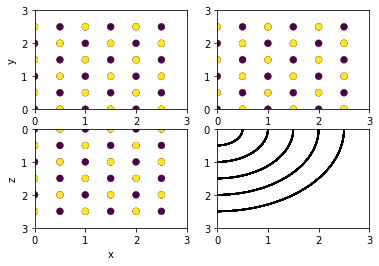

In [6]:
# orthograpic projection
f,sp = plt.subplots(2,2)
# xy
sp[0][0].set_xlim(0,Lx), sp[0][0].set_ylim(0,Ly)
sp[0][0].scatter( pos[:,0],pos[:,1],c=cha)
sp[0][0].set_ylabel('y')
# zy
sp[0][1].set_xlim(0,Lz), sp[0][1].set_ylim(0,Ly)
sp[0][1].scatter( pos[:,2],pos[:,1],c=cha)

# x(-z)
# note that the yaxis with the z coordinates is reversed, going from Lz to 0
sp[1][0].set_xlim(0,Lx), sp[1][0].set_ylim(Lz,0)
sp[1][0].scatter( pos[:,0],pos[:,2],c=cha)
sp[1][0].set_xlabel('x')
sp[1][0].set_ylabel('z')

sp[1][1].set_xlim(0,Lz), sp[1][1].set_ylim(Lz,0)
theta = np.linspace(0,np.pi/2)
for z in pos[:,2]:
    plt.plot(np.cos(theta)*z, np.sin(theta)*z,'k-')
plt.show()

In [7]:
max_eps = 1.e-7

def solve_eps_r( alpha, cell, N, eps ):
    return np.sqrt( (compute_eps_r(0, alpha, cell, N ) - eps)**2 )

from scipy.optimize import fsolve

zero_cell_alpha = fsolve( solve_eps_r, x0=1.0, args=(cell,N,max_eps))[0]

zero_cell_Kmax = find_Kmax( max_eps, zero_cell_alpha, cell, N )
print(zero_cell_alpha, 0, zero_cell_Kmax)

4.082180191152235e+00 0 16


In [8]:
alpha = zero_cell_alpha
Kmax = zero_cell_Kmax
k_xyz, c2 = generate_k(Kmax,cell,alpha)
S_k = gen_S( N, cha, pos, k_xyz )

In [9]:
PE_sr = U_sr(N,cha,pos,alpha,Lx,Ly,Lz)
PE_lr = U_lr(N,cha,pos,c2,S_k,alpha,cell.V)
PE_cr = U_cr(N,cha,alpha)
PE_fr = PE_sr + PE_lr + PE_cr
print(PE_fr * 2 / N)
print( PE_lr, PE_cr, PE_lr+PE_cr )

-3.4951291892674337
124.96753455699755 -497.4746850748252 -372.50715051782765


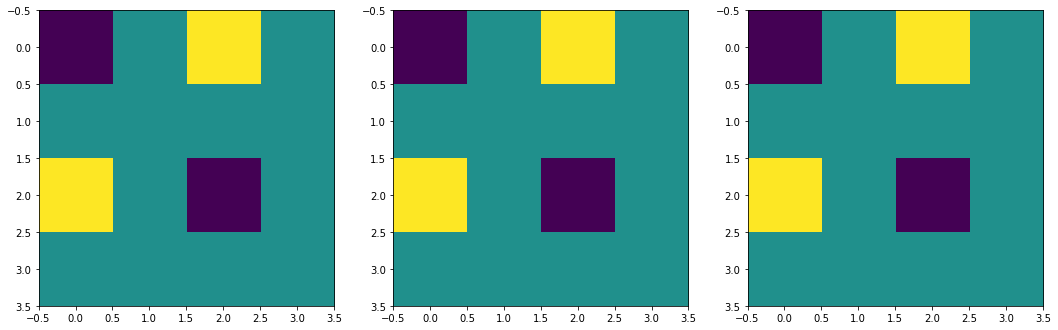

4.997940256425617


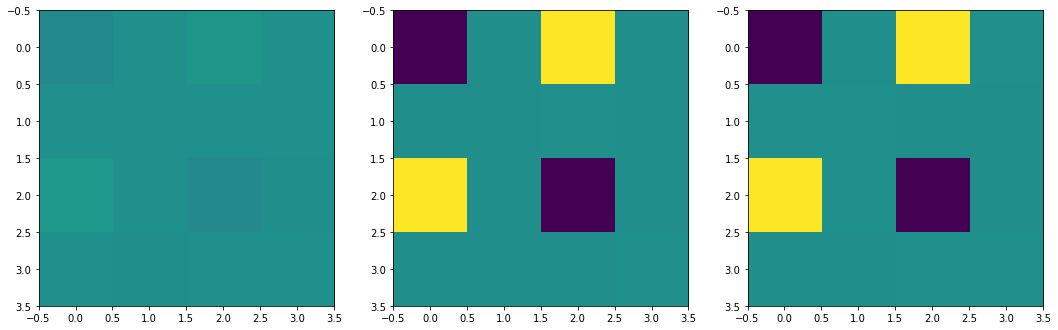

0.011916776704112631


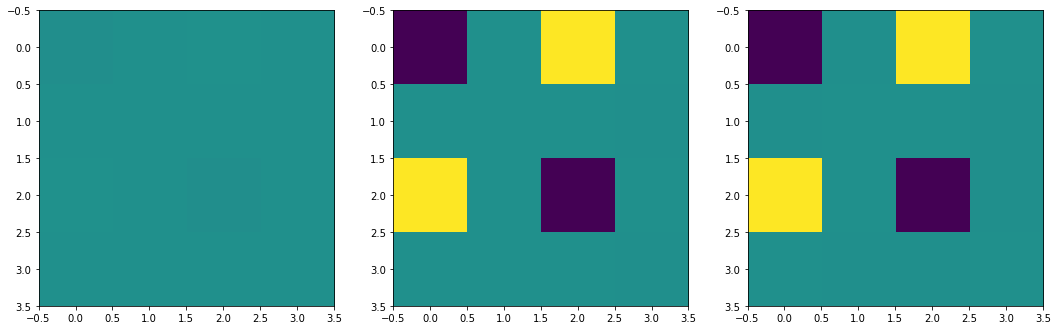

0.0016686102990490358


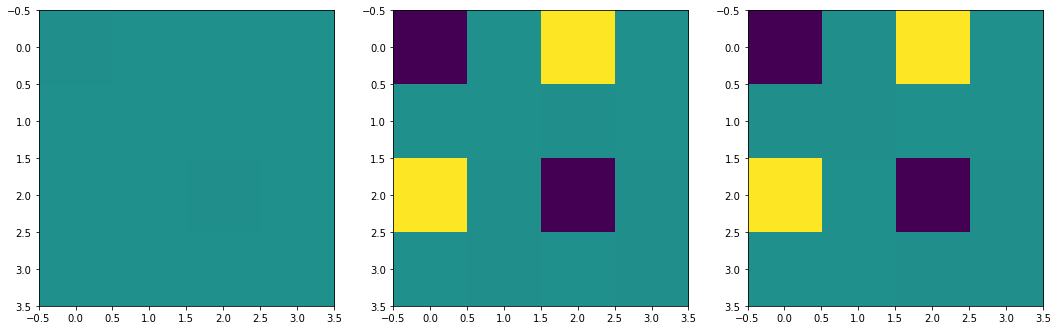

0.001282225910061772


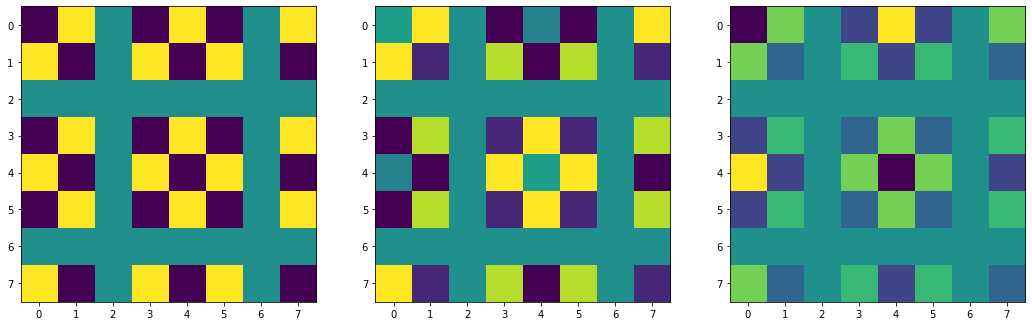

17.50329702416667


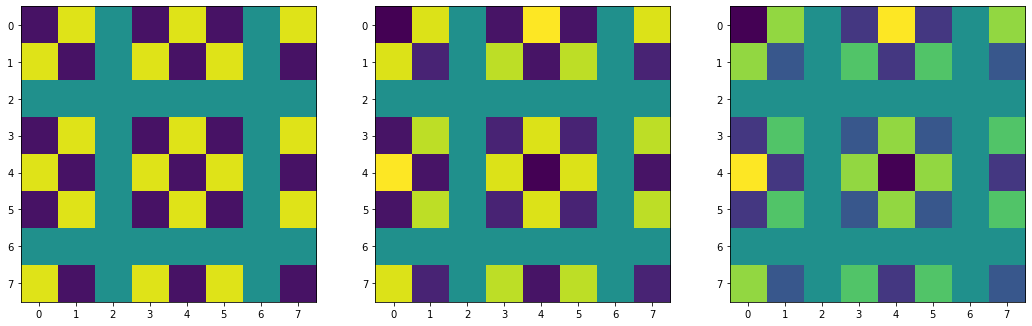

114.0402745377741


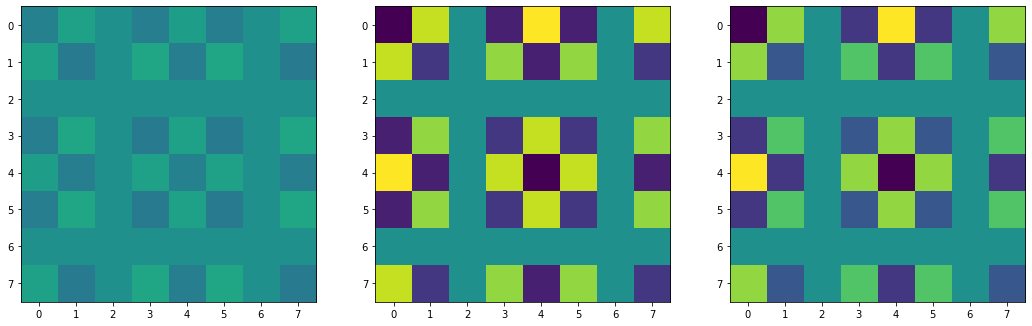

100.67662063603002


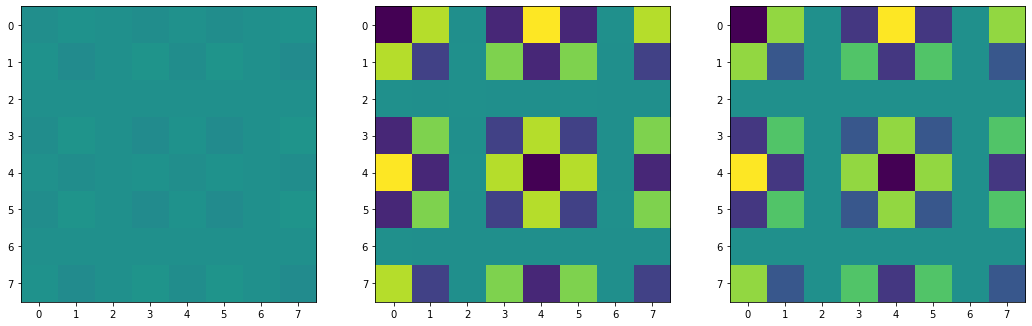

88.74399282512722


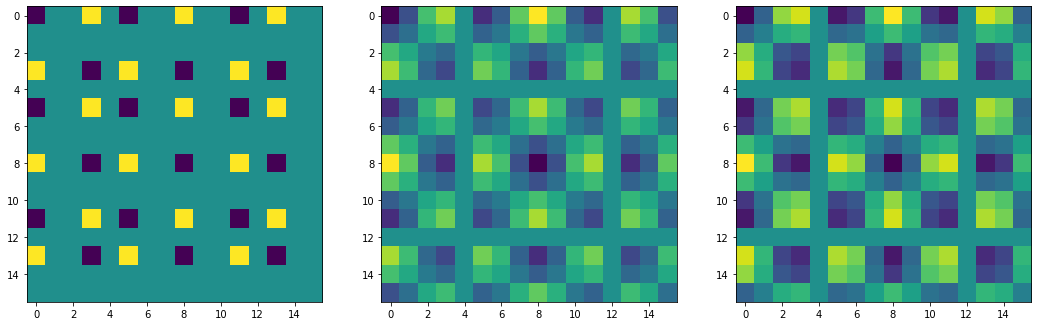

80.35413857497787


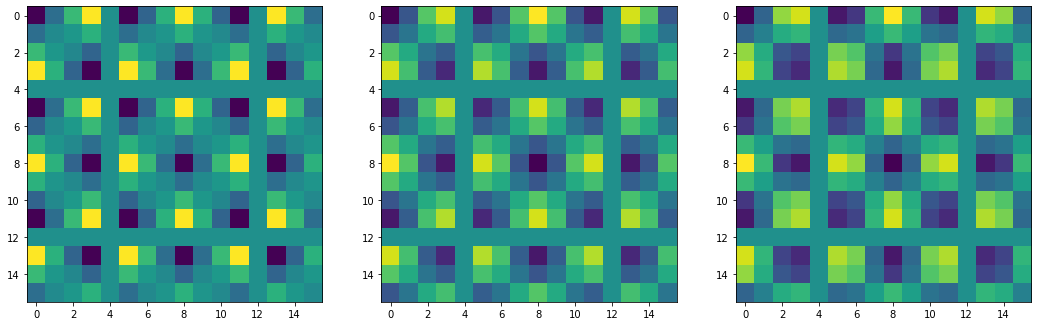

118.25392330952965


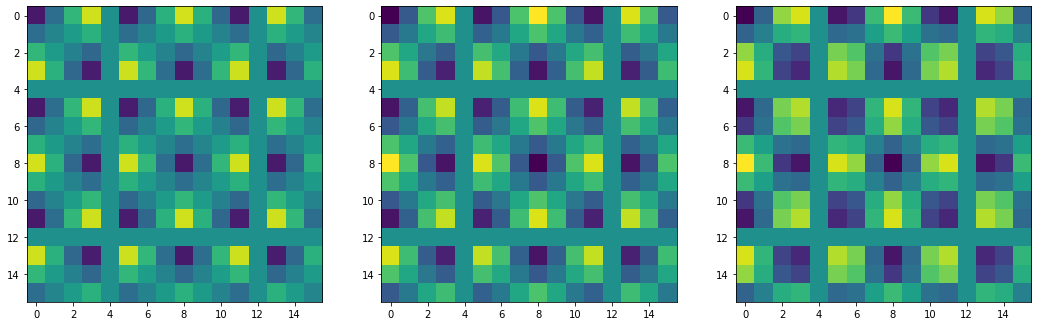

113.25657838098525


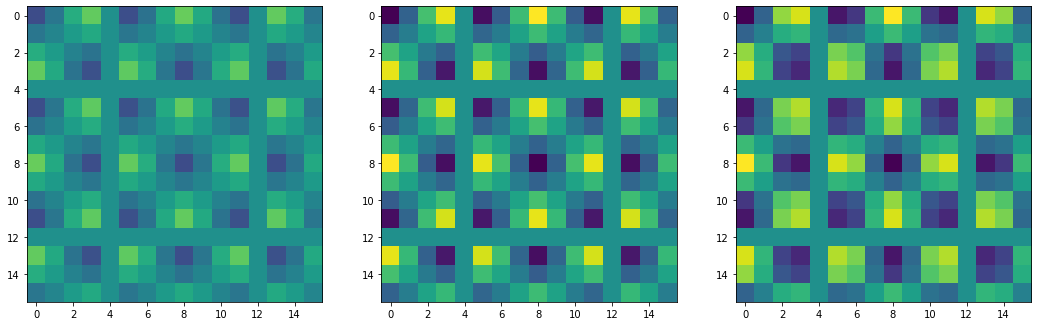

112.20330859115276


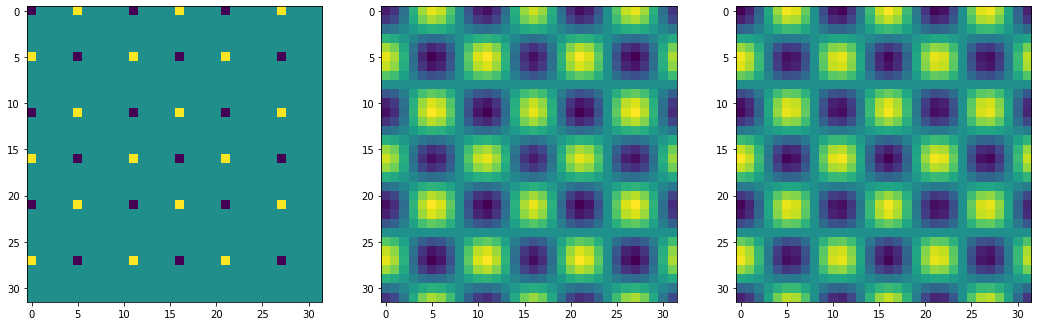

113.46884751790567


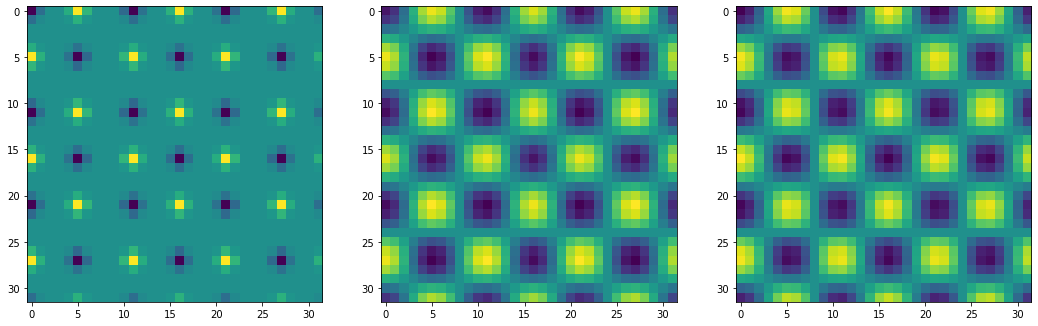

121.67919769000302


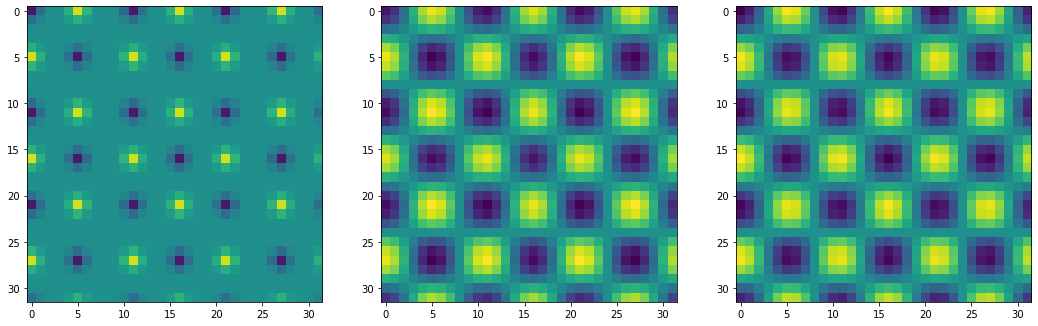

121.27473072623845


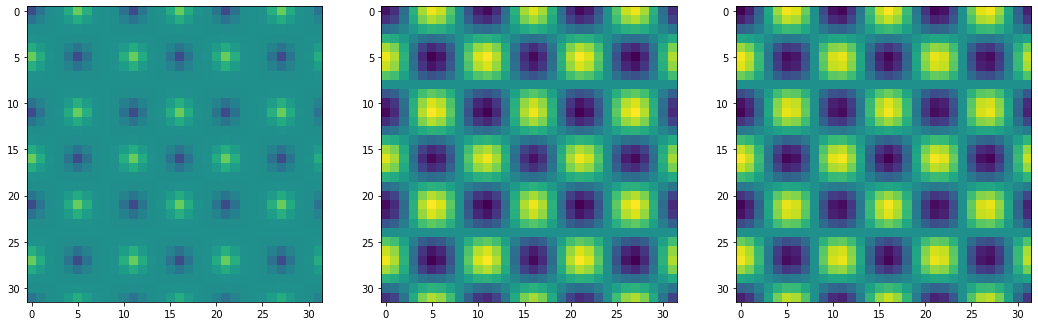

121.25641130448453


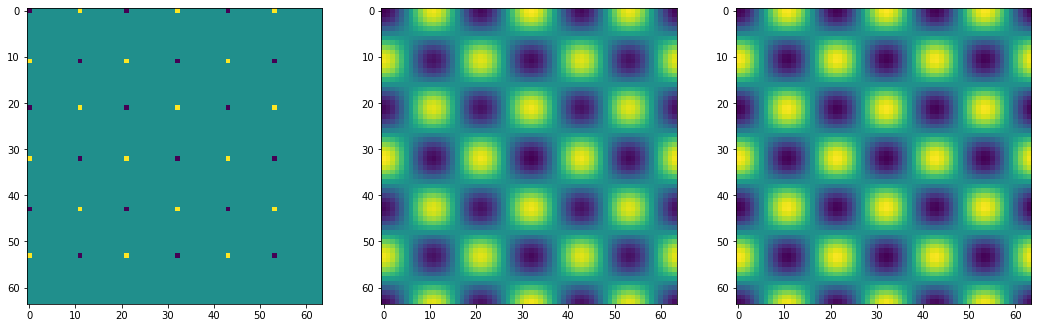

121.93023552801755


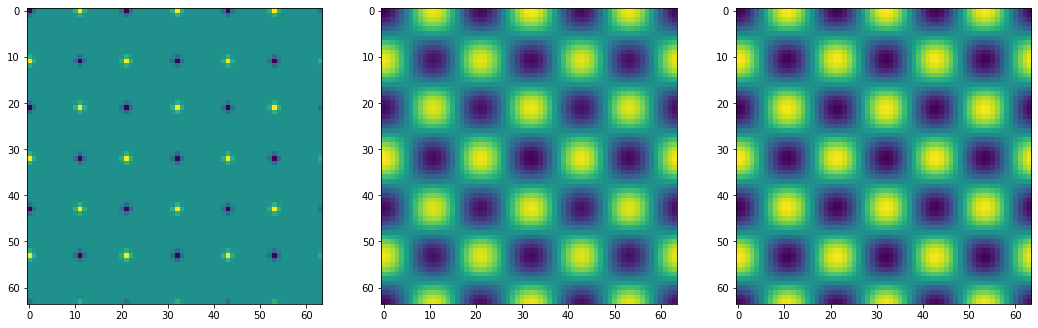

123.8639009789839


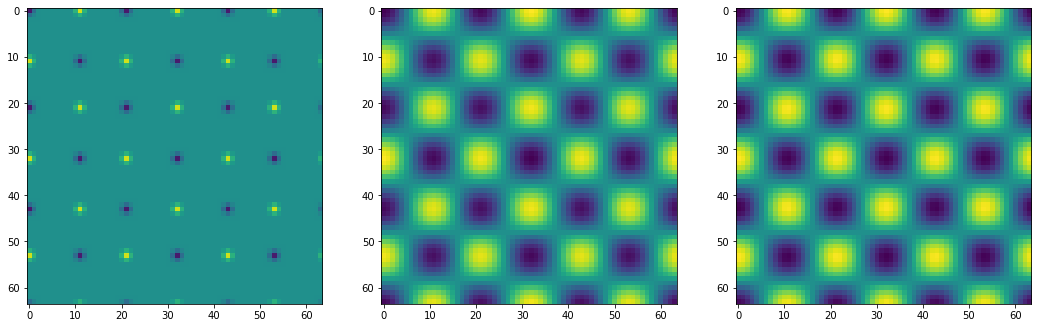

123.83911745203861


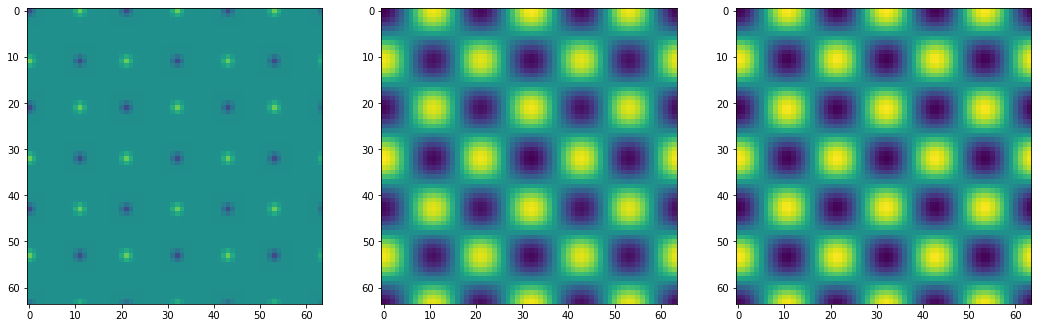

123.83888048863587


In [10]:
E_l = []

max_m = 3

alpha = zero_cell_alpha
for M in [4,8,16,32,64]:

    kx = 2 * np.pi * np.fft.fftfreq(M, cell.Lx/M)
    k_xyz = np.array(np.meshgrid(kx,kx,kx))
    k_xyz = k_xyz.reshape((3,-1)).T
    k_xyz_2 = np.sum(k_xyz**2,axis=1)
    b2 = k_xyz_2 / 4.0 / alpha / alpha
#    G = 4 * np.pi / (k_xyz_2+1.e-10) * np.exp( - b2 )
#    G[np.where( G > 3. * np.pi / (1.e-10) )] = 0.0
#    G = G.reshape((M,M,M))

    h = cell.Lx / M
    
    for P in [1,3,5,7]:
        
        G = np.empty(M**3)
        compute_G( G, k_xyz, max_m, alpha, M, P, cell.Lx )
        G = G.reshape((M,M,M))
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3 , figsize=(18, 9))
        Rr = to_grid( pos, cha, cell, M, P)
        ax1.imshow(Rr[:,:,M//2] , vmin=-1/(4*h**3), vmax=1/(4*h**3) )
        Rk = h**3 * np.fft.fftn(Rr)
        Vk = G * Rk

        Vr = np.fft.ifftn(Vk)
        ax2.imshow(Vr[:,:,M//2].real)

        Uk = Rk * Vk
        Ur = np.fft.ifftn(Uk)
        ax3.imshow(Ur[:,:,M//2].real)

        plt.show()
        E = 0.5 / cell.V * np.sum( Rk*Rk.conj() * G ).real
        E_l.append((M,P,E))
        print( E )

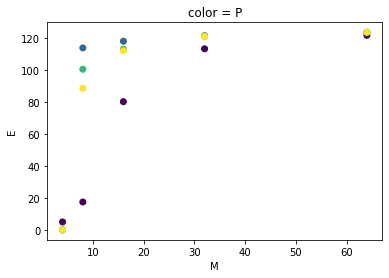

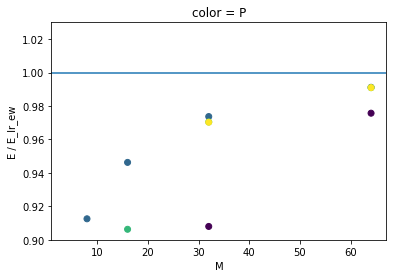

In [13]:
E_l = np.array(E_l)
M,P,E = E_l.T
plt.scatter(M,E,c=P)
plt.xlabel('M')
plt.ylabel('E')
plt.title('color = P')
plt.show()

plt.scatter(M,E/PE_lr,c=P)
plt.xlabel('M')
plt.ylabel('E / E_lr_ew')
plt.ylim(0.9,1.03)
plt.axhline(1.0)
plt.title('color = P')
plt.show()


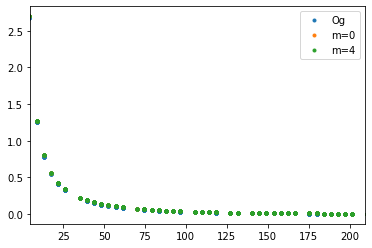

In [74]:
M = 64
Gs = []
kx = 2 * np.pi * np.fft.fftfreq(M, cell.Lx/M)
k_xyz = np.array(np.meshgrid(kx,kx,kx))
k_xyz = k_xyz.reshape((3,-1)).T
k_xyz_2 = np.sum(k_xyz**2,axis=1)
b2 = k_xyz_2 / 4.0 / alpha / alpha

G0 = 4 * np.pi / (k_xyz_2+1.e-10) * np.exp( - b2 )
G0[np.where( G0 > 3. * np.pi / (1.e-10) )] = 0.0
Gs.append(G0)


Gs = []
for max_m in range(5):
    G = np.empty( k_xyz.shape[0] )
    compute_G( G, k_xyz, max_m, alpha, M, 8, cell.Lx )
    Gs.append(G.copy())
    
plt.plot( k_xyz_2, G0   , '.' , label='Og')
plt.plot( k_xyz_2, Gs[0], '.' , label='m=0')
plt.plot( k_xyz_2, Gs[-1], '.' , label='m='+str(max_m))
plt.xlim( 2*np.pi/cell.Lx*2.3, 2*np.pi/cell.Lx*100)
plt.legend()
    

In [ ]:
plt.plot( k_xyz_2, Gs[1]*27*27, '.' )
plt.ylim(0,2.8)

In [ ]:
plt.plot(cell.Lx / 2 / np.pi * k_xyz, '.')